In [1]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
import time
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.001              #0.03
TrainingPercent = 80
ValidationPercent = 10          
TestPercent = 10
M = 10                #10
PHI = []
IsSynthetic = False

In [63]:
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
    dataMatrix = np.transpose(dataMatrix)
    #print ("Data Matrix Generated..")
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    #print("datarow is ",DataRow.shape)
    #print("murow is",MuRow.shape)
    #print("r is",R.shape)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    print("phi",PHI.shape)
    PHI_SQR     = np.dot(PHI_T,PHI)
    print("phi_t",PHI_T.shape)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    print("phi_sqr_li",PHI_SQR_LI.shape) 
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    print("intel",INTER.shape)
    print("t",T.shape)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):

    DataT = np.transpose(Data)

    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    print("big sig inv",BigSigInv.shape)
    print("mu shape",MuMatrix.shape)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
   
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ######accuracy.append(float((counter*100))/float(len(VAL_TEST_OUT)))
    
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

    ###return str(accuracy), str(math.sqrt(sum/len(VAL_TEST_OUT)))

## Fetch and Prepare Dataset

In [12]:
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)
print(type(RawData))

d:\python\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
d:\python\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


<class 'numpy.ndarray'>


## Prepare Training Data

In [23]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingTarget)
print(TrainingData.shape)
print(TrainingData)

(55699,)
[0 1 1 ... 0 0 0]
(41, 55699)
[[0.       0.03131  0.078682 ... 0.021157 0.057828 0.52891 ]
 [0.       0.66667  0.16667  ... 0.       0.125    0.125   ]
 [0.       0.5      0.5      ... 0.5      1.       0.5     ]
 ...
 [0.       0.33333  0.83333  ... 0.42857  0.57143  0.42857 ]
 [0.       0.44828  0.67816  ... 0.24615  0.40769  0.17692 ]
 [0.       0.       0.       ... 0.       0.       0.      ]]


## Prepare Validation Data

In [14]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValDataAct)
print(ValData.shape)

(6962,)
[0 0 0 ... 0 1 0]
(41, 6962)


## Prepare Test Data

In [15]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


In [67]:
print(TrainingTarget.shape)

(55699,)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

In [68]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
print(TrainingData.shape)
print(kmeans)
Mu = kmeans.cluster_centers_
print("1",Mu.shape)
BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 

TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

(41, 55699)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
1 (10, 41)
big sig inv (41, 41)
mu shape (10, 41)
phi (55699, 10)
phi_t (10, 55699)
phi_sqr_li (10, 10)
intel (10, 55699)
t (55699,)
big sig inv (41, 41)
mu shape (10, 41)
big sig inv (41, 41)
mu shape (10, 41)


In [71]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(W)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(10, 41)
(41, 41)
(55699, 10)
(10,)
[-9.80924066  4.35844998 -0.37296405 -6.37688022  0.42949966  2.19679523
  0.70688469  6.68209097  2.14983104  0.60619486]
(6962, 10)
(6961, 10)


## Finding Erms on training, validation and test set 

In [72]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

print(TrainingAccuracy)
print(ValidationAccuracy)
print(TestAccuracy)

73.90796962243488,0.549454689512538
74.6337259408216,0.5384290693157395
69.90374946128429,0.6278388560929666


In [11]:
print ('UBITname      = haoruido')
print ('Person Number = 50291149')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = "+ str(M))
print ("C_Lambda = " + str(C_Lambda))
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))

UBITname      = haoruido
Person Number = 50291149
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10
C_Lambda = 0.001
E_rms Training   = 0.549454689512538
E_rms Validation = 0.5384290693157395
E_rms Testing    = 0.6278388560929666


## Gradient Descent solution for Linear Regression

In [12]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [13]:
W_Now        = np.dot(220, W)
La           = 2    #####2
learningRate = 0.01  #####0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
L_acc_Test   = []
L_acc_VAL    = []
L_acc_TR     = []

N = 400
for i in range(N):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    #print (Erms_TR)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_acc_TR.append(float(Erms_TR.split(',')[0]))
    #print(L_Erms_TR)
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    L_acc_VAL.append(float(Erms_Val.split(',')[0]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    #print (Erms_Test)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    #print (L_Erms_Test)
    L_acc_Test.append(float(Erms_Test.split(',')[0]))
    #print (L_acc_Test)
    print("progress:{0}%".format(round((i + 1) * 100 / N)), end="\r")

In [14]:
print ('----------Gradient Descent Solution--------------------')
print ("M = 15 \nLambda  = 0.0001\neta=0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
print ("Accuracy Testing    = " + str(np.around(max(L_acc_Test),5)))
print ("Accuracy Training    = " + str(np.around(max(L_acc_TR),5)))
print ("Accuracy validation    = " + str(np.around(max(L_acc_VAL),5)))

----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 0.54962
E_rms Validation = 0.53849
E_rms Testing    = 0.6236
Accuracy Testing    = 70.32036
Accuracy Training    = 74.52198
Accuracy validation    = 75.25136


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000209B255E080>,
      dtype=object)

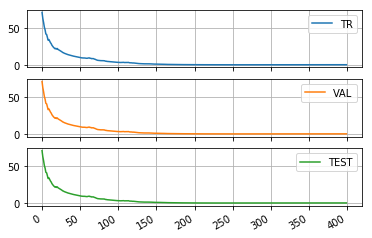

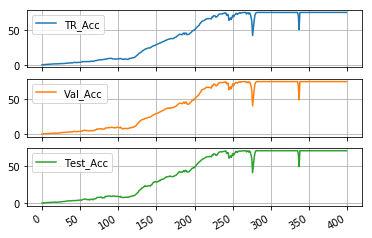

In [15]:
df = pd.DataFrame()
df['TR'] =  L_Erms_TR
df['VAL'] = L_Erms_Val
df['TEST'] = L_Erms_Test
df.plot(subplots=True,grid=True)

df2 = pd.DataFrame()
df2['TR_Acc'] =  L_acc_TR
df2['Val_Acc'] = L_acc_VAL
df2['Test_Acc'] = L_acc_Test
df2.plot(subplots=True,grid=True)